In [0]:
# 구글드라이브 연동
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Fashion MNIST 예측

## Load date

In [1]:
import pandas as pd
import numpy as np


Train = pd.read_csv('./gdrive/My Drive/Data_Mining/fashion-mnist_train.csv')
Test = pd.read_csv('./gdrive/My Drive/Data_Mining/fashion-mnist_test.csv')
print(Train.shape)
print(Test.shape)
Train.head()

(60000, 785)
(10000, 785)


label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

## Reshape data

In [2]:
Train = np.array(Train)
Test = np.array(Test)

X_train = Train[:, 1:]
y_train = Train[:, 0]
X_test = Test[:, 1:]
y_test = Test[:, 0]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [3]:
from keras.utils import np_utils


X_train = X_train.reshape(-1, 28, 28, 1).astype('float32')/255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')/255
Y_train = np_utils.to_categorical(y_train, num_classes = 10)
Y_test = np_utils.to_categorical(y_test, num_classes = 10)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Using TensorFlow backend.


(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


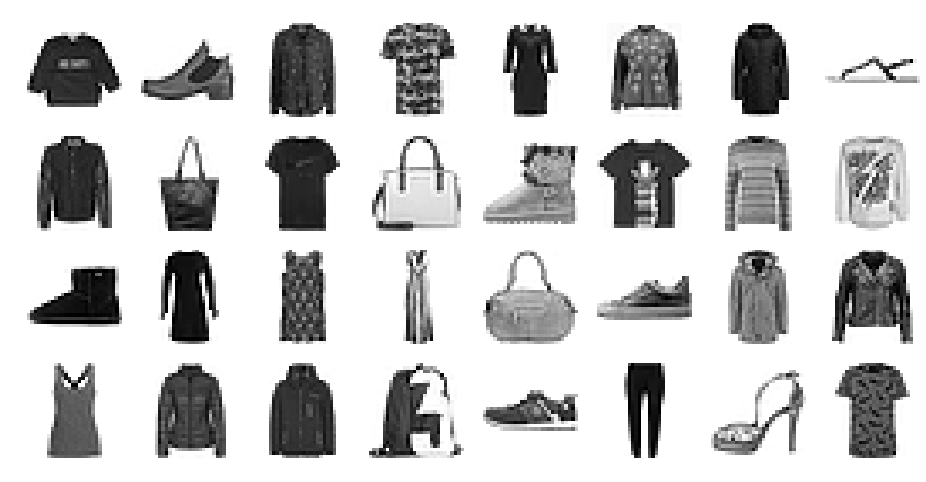

In [4]:
import matplotlib.pyplot as plt


#Y_categ = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(4, 8, figsize = (16, 8))
ax = ax.ravel()
for i in range(32):
    ax[i].imshow(X_train[i, :, :, :].reshape(28, 28), cmap='binary')
    ax[i].set_title(y_train[i], color='white')
    ax[i].axis('off')
plt.show()

## Model - tensorflow

In [17]:
import tensorflow as tf
import random



input_dim = (28, 28, 1)
output_dim = 10
lr = 0.001
epoch = 10
batch_size = 100

# 변수 초기화
tf.reset_default_graph()


X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])


W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev = 0.01))
L1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding = 'SAME')
print("Conv. Layer 1 : ", L1)
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding = 'SAME')
print("Pool. Layer 1 : ", L1)

W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev = 0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding = 'SAME')
print("Conv. Layer 2 : ", L2)
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding = 'SAME')
print("Pool. Layer 2 : ", L2)

L2_flat = tf.reshape(L2, [-1, 7 * 7 * 64])
print("Fully Con. Layer : ", L2_flat)
W3 = tf.get_variable("W3", shape=[7 * 7 * 64, 10], initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L2_flat, W3) + b
print("Output : ", logits)


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Conv. Layer 1 :  Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Pool. Layer 1 :  Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Conv. Layer 2 :  Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
Pool. Layer 2 :  Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
Fully Con. Layer :  Tensor("Reshape:0", shape=(?, 3136), dtype=float32)
Output :  Tensor("add:0", shape=(?, 10), dtype=float32)


In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Learning started. It takes sometime.')
    for e in range(epoch):
        avg_cost = 0
        n_batch = 60000//batch_size  ### n_batch: 한 회당 (60000//batch_size) 번 씩 나누어서 돌림
        for i in range(n_batch):
            batch_xs = X_train[i*batch_size:i*batch_size+batch_size, :, :, :]  ### X_train을 100개씩 나누기
            batch_ys = Y_train[i*batch_size:i*batch_size+batch_size, :]        ### Y_train도 마찬가지.
            feed_dict = {X : batch_xs, Y : batch_ys}
            c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
            avg_cost += c / n_batch  ### cost계산 
        accu = accuracy.eval(feed_dict={X: X_train, Y: Y_train})
        print('Epoch:', '%02d' % (e + 1), '  Cost =', '{:.9f}'.format(avg_cost), '  Accuracy = {:.4f}'.format(accu))

    print('Learning Finished!\n')
    cost = cost.eval(feed_dict={X : X_test, Y : Y_test})
    accu = accuracy.eval(feed_dict={X : X_test, Y : Y_test})
    print('[Result]')
    print('Cost     : {:.8f}'.format(cost))
    print('Accuracy : {:.4f}'.format(accu))

Learning started. It takes sometime.
Epoch: 01   Cost = 0.599013407   Accuracy = 0.8565
Epoch: 02   Cost = 0.379910355   Accuracy = 0.8793
Epoch: 03   Cost = 0.340296825   Accuracy = 0.8903
Epoch: 04   Cost = 0.316553291   Accuracy = 0.8969
Epoch: 05   Cost = 0.298074543   Accuracy = 0.9013
Epoch: 06   Cost = 0.282727934   Accuracy = 0.9060
Epoch: 07   Cost = 0.269244095   Accuracy = 0.9105
Epoch: 08   Cost = 0.257049195   Accuracy = 0.9148
Epoch: 09   Cost = 0.245355631   Accuracy = 0.9182
Epoch: 10   Cost = 0.234563251   Accuracy = 0.9222
Learning Finished!

[Result]
Cost     : 0.26440030
Accuracy : 0.9069


## Model - keras

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D



# model parameters
input_dim = (28, 28, 1)
output_dim = 10
lr = 0.001
epoch = 10
batch_size = 128


model = Sequential()
model.add(Conv2D(input_shape = input_dim, filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=96, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 48)        13872     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 28, 28, 64)        27712     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 14, 14, 96)        55392     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 128)       110720    
__________

## Train

In [0]:
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.99)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 14s 302us/step - loss: 0.5759 - acc: 0.7940 - val_loss: 0.3254 - val_acc: 0.8823
Epoch 2/10
48000/48000 [==============================] - 13s 272us/step - loss: 0.3274 - acc: 0.8825 - val_loss: 0.2586 - val_acc: 0.9088
Epoch 3/10
48000/48000 [==============================] - 13s 274us/step - loss: 0.2735 - acc: 0.9016 - val_loss: 0.2321 - val_acc: 0.9172
Epoch 4/10
48000/48000 [==============================] - 13s 272us/step - loss: 0.2398 - acc: 0.9121 - val_loss: 0.2150 - val_acc: 0.9241
Epoch 5/10
48000/48000 [==============================] - 13s 268us/step - loss: 0.2204 - acc: 0.9218 - val_loss: 0.2102 - val_acc: 0.9267
Epoch 6/10
48000/48000 [==============================] - 13s 272us/step - loss: 0.1987 - acc: 0.9272 - val_loss: 0.2147 - val_acc: 0.9223
Epoch 7/10
48000/48000 [==============================] - 13s 271us/step - loss: 0.1870 - acc: 0.9324 - val_loss: 0.

## Result

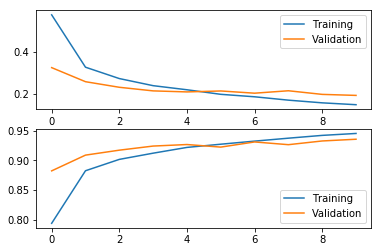

In [0]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].legend(['Training', 'Validation'])
ax[1].plot(hist.history['acc'])
ax[1].plot(hist.history['val_acc'])
ax[1].legend(['Training', 'Validation'])
plt.show()

In [0]:
loss, acc = model.evaluate(X_test, Y_test)
print('Loss     : {:.8f}'.format(loss))
print('Accuracy : {:.4f}'.format(acc))

10000/10000 [==============================] - 1s 114us/step
Loss     : 0.18526115
Accuracy : 0.9369


In [0]:
import pandas as pd


pred = model.predict_classes(X_test)
actual = y_test.reshape(-1)
crosstab = pd.crosstab(pred, actual, rownames=['Pred'], colnames=['Actual'])
crosstab

Actual    0    1    2    3    4    5    6    7    8    9
Pred                                                    
0       911    0   14    9    0    0   95    0    0    0
1         0  993    0    5    0    1    0    0    1    0
2        20    0  883    6    9    0   39    0    1    0
3         7    5   12  948   20    0   27    0    0    0
4         0    0   61   13  931    0   43    0    0    0
5         0    0    0    0    0  964    0    2    0    0
6        61    2   30   19   39    0  793    0    5    0
7         0    0    0    0    0   14    0  974    0   20
8         1    0    0    0    1    2    3    0  992    0
9         0    0    0    0    0   19    0   24    1  980

<br><br><br><br><br><br><br><br>

# Cifar-10 예측

[데이터 다운](https://pjreddie.com/projects/cifar-10-dataset-mirror/)
(근데 파일갯수가 너무 많아서 압축이 안풀어짐...)

## Load data

In [0]:
### 걍 이렇게 가져와야할듯

from keras.datasets import cifar10


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


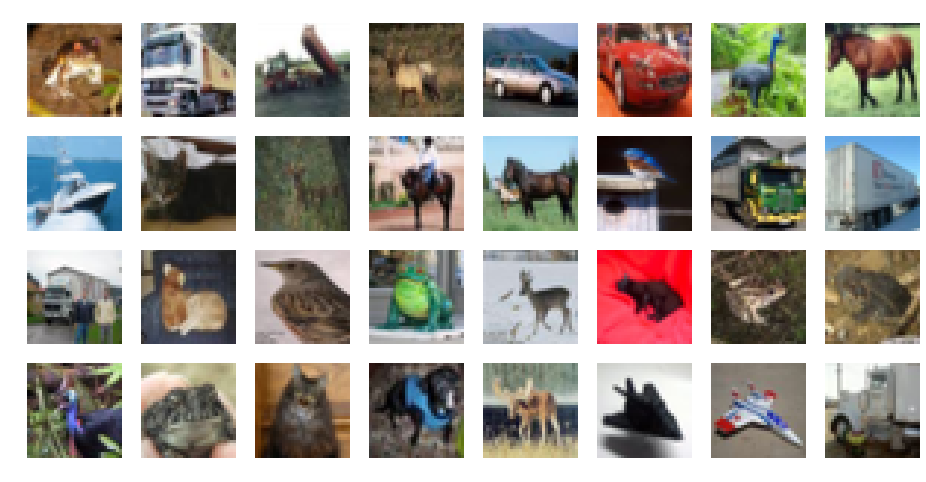

In [0]:
import matplotlib.pyplot as plt


Y_categ = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(4, 8, figsize = (16, 8))
ax = ax.ravel()
for i in range(32):
    ax[i].imshow(X_train[i, :, :, :])
    ax[i].set_title(Y_categ[y_train[i].item()], color='white')
    ax[i].axis('off')
plt.show()

## Reshape data

In [0]:
from keras.utils import np_utils


X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
Y_train = np_utils.to_categorical(y_train, num_classes=10).astype(int)
Y_test = np_utils.to_categorical(y_test, num_classes=10).astype(int)

## Model 

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D



# model parameters
input_dim = (32, 32, 3)
output_dim = 10
lr = 0.001
epoch = 15
batch_size = 128


model = Sequential()
model.add(Conv2D(input_shape = input_dim, filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=96, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Flatten())
model.add(Dense(units=512, activation = 'relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=128, activation = 'relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=10, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 48)        13872     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 48)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        27712     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 96)        55392     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 96)          0         
__________

## Train

In [0]:
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.99)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 9s 225us/step - loss: 1.8185 - acc: 0.3160 - val_loss: 1.4080 - val_acc: 0.4774
Epoch 2/15
40000/40000 [==============================] - 7s 185us/step - loss: 1.3573 - acc: 0.5022 - val_loss: 1.2532 - val_acc: 0.5460
Epoch 3/15
40000/40000 [==============================] - 7s 182us/step - loss: 1.1608 - acc: 0.5870 - val_loss: 1.0546 - val_acc: 0.6268
Epoch 4/15
40000/40000 [==============================] - 7s 183us/step - loss: 1.0096 - acc: 0.6445 - val_loss: 0.8801 - val_acc: 0.6908
Epoch 5/15
40000/40000 [==============================] - 7s 183us/step - loss: 0.9035 - acc: 0.6841 - val_loss: 0.7888 - val_acc: 0.7220
Epoch 6/15
40000/40000 [==============================] - 7s 182us/step - loss: 0.8332 - acc: 0.7122 - val_loss: 0.7493 - val_acc: 0.7390
Epoch 7/15
40000/40000 [==============================] - 7s 187us/step - loss: 0.7675 - acc: 0.7349 - val_loss: 0.7341 - 

## Result

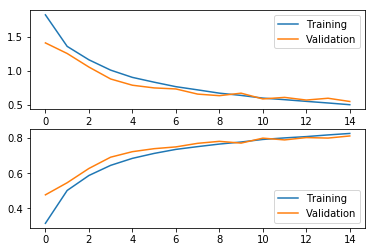

In [0]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].legend(['Training', 'Validation'])
ax[1].plot(hist.history['acc'])
ax[1].plot(hist.history['val_acc'])
ax[1].legend(['Training', 'Validation'])
plt.show()

In [0]:
loss, acc = model.evaluate(X_test, Y_test)
print('Loss     : {:.8f}'.format(loss))
print('Accuracy : {:.4f}'.format(acc))

10000/10000 [==============================] - 1s 107us/step
Loss     : 0.56491743
Accuracy : 0.8066


In [0]:
import pandas as pd


pred = model.predict_classes(X_test)
actual = y_test.reshape(-1)
crosstab = pd.crosstab(pred, actual)
crosstab.columns = pd.Series(Y_categ, name = 'Actual')
crosstab.index = pd.Series(Y_categ, name = 'Pred')
crosstab

Actual      airplane  automobile  bird  cat  deer  dog  frog  horse  ship  \
Pred                                                                        
airplane         786           5    43   11    15    3     7      9    16   
automobile        14         917     1    5     3    3     3      1    14   
bird              30           1   721   66    48   53    31     41     7   
cat               16           2    39  668    55  178    33     49     8   
deer              12           2    70   35   793   37     9     56     3   
dog                1           1    26   92    10  657     8     27     1   
frog               7           7    64   87    52   34   893      7     5   
horse             10           1    12   15    15   27     5    801     1   
ship              90          11    17   13     6    5     9      4   930   
truck             34          53     7    8     3    3     2      5    15   

Actual      truck  
Pred               
airplane        5  
automobile     53  
bird            4  
cat            13  
deer            2  
dog             1  
frog            5  
horse           2  
ship           15  
truck         900

In [0]:
print('{:.4f}'.format(np.pi))

3.1416
